# Chapter 33   
# Basic Time Series Forecasting Models 

## Introduction

<center> "It's tough to make predictions, especially about the future!"</center>    

<center>Karl Kristian Steincke, Danish politician, ca 1937</center>   

In the pervious chapter we explored some key properties of time series. Now, we will apply these foundations as we explore basic linear forecasting models. These linear models are used in many forcasting applications. Further, these models are a base on which more advanced time series models are constructed. 

In this chapter we will explore two widely used families of models. **Autoregressive integrative moving average (ARIMA) models** are based on the ACF, PACF and differencing properties of time series. Key topics for forecasting models discussed in this lesson include:    

1. The components that comprise basic autoregressive integrative moving average (ARIMA) models.         
3. Statistical properties of these models such as confidence intervals.    

**Exponential models** are based on different orders of exponential smoothing of time series. Exponential smoothing models are often a good alternative to the ARIMA family of models. In any particular real-world case either family of models might provide lower forecasting errors. Careful testing is required to determine which family of model is best. A brief treatment of exponential smoothing models can be found in the appendix to this chapter A more complete introduction can be found in Chapter 8 of [Hyndman and Athanasopoulos, 2021](https://otexts.com/fpp3/).       

To run the code in this notebook, you must exectue the code in the cell below to import the required packages and instantiate some required funcitons. 

In [1]:
from math import sin
import pandas as pd
import numpy as np
import numpy.random as nr
from math import pi
from scipy.stats import zscore
import sklearn.linear_model as lm
import statsmodels.tsa.seasonal as sts
import scipy.stats as ss
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools 
import pmdarima as pm
import statsmodels.graphics.tsaplots as splt
import matplotlib.pyplot as plt
import warnings 

%matplotlib inline

def plot_ts(ts, lab = '', xlab='Date', ax=None):
    if ax == None: _,ax = plt.subplots(figsize=(9,4))
    ts.plot(ax=ax)
    ax.set_title('Time series plot of ' + lab)
    ax.set_ylabel('Value')
    ax.set_xlabel(xlab)
    
def dist_ts(ts, lab = '', bins = 40):
    _,ax = plt.subplots(1,2,figsize=(10,4))
    ## Plot the histogram with labels
    ts.hist(ax = ax[0], bins = bins, alpha = 0.5);
    ax[0].set_xlabel('Value');
    ax[0].set_ylabel('Frequency');
    ax[0].set_title('Histogram of ' + lab);
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax[1]);
    
def auto_partial_corr_plot(ts):
    _,ax = plt.subplots(2,1, figsize=(8,8))
    _=splt.plot_acf(ts, lags = 40, ax=ax[0]);
    _=splt.plot_pacf(ts, lags = 40, method='yw', ax=ax[1]);
    
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) 
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )        

def test_stationarity(series, regression_model='c', rounding=3):
    """Function to test the stationarity of time series using:
    1. Augmented Dicky Fuller test using AIC 
    2. KPSS test for constant
    
    Arguments:  
        Series: the time series to be evaluated.   
        regression_model: model to be used:   
            'c' - model with a constant   
            'ct' - model wiht a constant and trend  
        rounding: the number of digits to display in printed output.   
    """
    if regression_model not in ['c','ct']:    
        print('Error!: argument regression model must be one of {\'c\',\'ct\'}')
        return
    with warnings.catch_warnings(): 
        warnings.filterwarnings("ignore")
        kpss_test = kpss(series, regression=regression_model)
        ADF_test = adfuller(series, regression=regression_model, autolag="AIC")
    return [round(ADF_test[0],rounding), round(ADF_test[4]['5%'],rounding), round(ADF_test[1],rounding),
                                       round(kpss_test[0],rounding), round(kpss_test[1],rounding)]
def stationary_tests(series, names, regression_model='c', rounding=3):
    test_columns = ['ADF_statistic','ADF_conf_int','ADF_p_value','KPSS_statistic','KPSS_p_value']
    out = pd.DataFrame(index=names, columns=test_columns)    
    for ser, name in zip(series,names):  
        out.loc[name,:] = test_stationarity(ser, regression_model=regression_model, rounding=rounding)
    return out

def auto_partial_corr_plot(ts, lags=40):
    _,ax = plt.subplots(2,1, figsize=(8,8))
    _=splt.plot_acf(ts, lags=lags, ax=ax[0]);
    _=splt.plot_pacf(ts, lags=lags, method='yw', ax=ax[1]);
    
nr.seed(6677)
def trend(start = '1-1990', end = '1-2015', freq = 'M', slope = 0.02, sd = 0.5, mean = 0):
    dates = pd.date_range(start = start, end = end, freq = freq)
    trend = pd.Series([slope*x for x in range(len(dates))],
                    index = dates)
    trend = trend + nr.normal(loc = mean, scale = sd, size = len(dates))
    return(trend)

def dist_ts(ts, lab = '', bins = 40):
    _,ax = plt.subplots(1,2,figsize=(10,4))
    ## Plot the histogram with labels
    ts.hist(ax = ax[0], bins = bins, alpha = 0.5);
    ax[0].set_xlabel('Value');
    ax[0].set_ylabel('Frequency');
    ax[0].set_title('Histogram of ' + lab);
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax[1]);

                              
trends = trend()       

## Setup to Run This Notebook  

This notebook was built and tested using the Anaconda 3.7 stack. In order to run the code in this notebook you must install the Python [pmdarima](http://alkaline-ml.com/pmdarima/) package which is not part of the standard Anaconda distribution. Follow these instructions to [pip install](https://alkaline-ml.com/pmdarima/setup.html#setup) this package with the command `pip install pmdarima`. Depending on your system configuration you may need to use the command `pip install --user pmdarima`.  You can also [conda install](https://anaconda.org/saravji/pmdarima) with the command `conda install -c saravji pmdarima`.

## Autoregressive Integrative Moving Average Model      

We **Autoregressive Integrative Moving Average (ARIMA) Model** is one of the most widely used in time eries forecasting. As the name implies, the ARIMA model is comprised of three components:     
1. An **autoregressive (AR) component** models the extent to wich past values of a time series predict future values.     
2. The **integrative (I) component** models the random walk and trend components of a time series. We have aleady seen how differencing can remove trend and random walk components of a time series. Integration is the inverse operation of differentiation and therefore provides a useful model for these components.     
3. The **moving average (MA) component** models how forecasts of future values can be improved by accounting for past errros. Note that here we use the term 'moving average' as the average of the erors at various lags, not a running average of the time series values themselves.      

We can construct a number of models from these compoents, depending on the properties of the time series. For example, time series with only autoregressive behavior can be modeled with an AR model. Likewise, a model with pure moving average behavior can be modeled with an MA model. A model with both properties, but no trend or random walk components can be modeled with an ARMA model.   

## Autoregressive Model

The values of an **autoregressive** or **AR** time series are determined by a linear combination of the past values. In other words, the **AR model accounts for serial correlation** in the values of the time series. We can write the value of an autoregressive series of **order p** or **AR(p)** series at time t as:

$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2}, \ldots, \phi_p y_{t-p} + \epsilon_t$$

Where:    
$c =$ a constatant   
$\phi_k =$ model coefficient at lag k    
$\epsilon_t \sim \mathtt{N}(0,\sigma^2)$; white noise error at time $t$      
$y_t =$ observation at time t   

An AR process has the following partial autocorrelation properties:

- $\rho_0 = 1$ always.
- $p_k = \alpha^k$
- Number of nonzero PACF values = p.

AR models are specifically for **stationary time series**. In the preceeding chapter we said that an AR model is non-stationary if it has a unit root. A consequence of this situation is that the model is **not invertable** and there is no solution for computing the model coefficients. In other terminology, a model with a unit root is said to be **non-identifiable**. To understsand this consider that an AR(1) model with unit root is a random walk with the $\phi_1=0$:    

$$y_t = \sum_{i=1}^t w_i$$           

Attempting to invert an equation with a zero root leads to an infinity. Hence the non-invertability of the model.   

### Examples of AR time series   

The code in the cell below contains two functions. One function computes a simulated time series using AR and moving average models. The second function calls the first function to create plots of a list of AR models.       

The `ARMA_simulate` function in the code in the cell below does the following:
1. Defines an ARMA process of the specified orders, ar_coef, ma_coef, using [statsmodels.tsa.arima_process.ArmaProcess](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ArmaProcess.html).    
2. Tests the stationarity and invertability (stability) of the process, using  [statsmodels.tsa.arima_process.ArmaProcess.isstationary](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ArmaProcess.isstationary.html) and [statsmodels.tsa.arima_process.ArmaProcess.isinvertible](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ArmaProcess.isinvertible.html). This is analogous to testing the invertablity of other linear models.    
3. Returns a Pandas series with samples generated from the ARMA process. Note that the [statsmodels.tsa.arima_process.ArmaProcess.generate_sample](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ArmaProcess.generate_sample.html) function adds white noise with standard deviation of 1.0 unless otherwise specified.    

The `plot_simulations` function iterates over lists of AR and MA coefficients. In each iteration the `ARMA_simulate` function is called and a plot is created.      

The code in the cell below simulates and plots a series of AR models. The AR models are defined by a list of lists of the model coeffcients. The first coefficient for a Statsmodels AR or MA model must be 1.0. As a result, an AR(0.8) model must be specified with coefficients $[1.0, 0.8]$. We are not using any moving average terms for these models. The MA(0) coefficients must be specified as $[1.0]$. Execute this code and examine the results.     

Is the time series stationary? True
Is the time series invertable? True
Is the time series stationary? True
Is the time series invertable? True
Is the time series stationary? True
Is the time series invertable? True
Is the time series stationary? True
Is the time series invertable? True


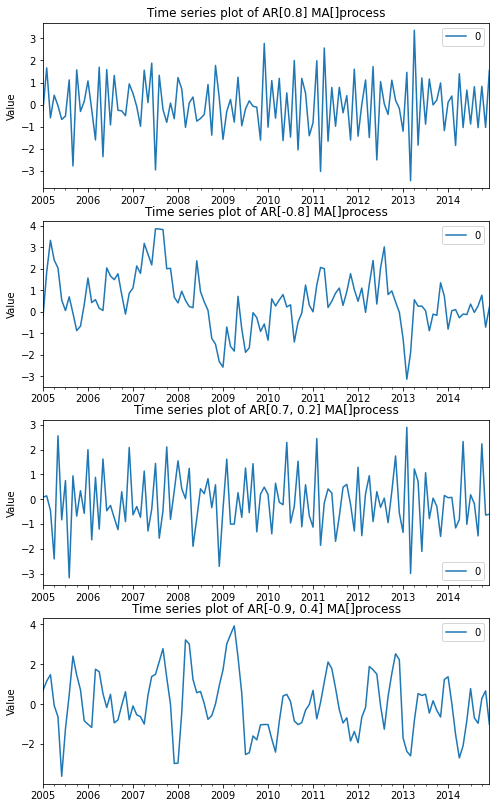

In [2]:
def ARMA_simulate(ar_coef, ma_coef, start = '1-2005', end = '1-2015', scale=1.0):
    dates = pd.date_range(start = start, end = end, freq = 'M')
    ts = arima.ArmaProcess(ar=ar_coef, ma=ma_coef, nobs=len(dates))
    print('Is the time series stationary? ' + str(ts.isstationary))
    print('Is the time series invertable? ' + str(ts.isinvertible))
    return(pd.DataFrame(ts.generate_sample(nsample=len(dates)), index=dates))

def plot_simulations(ar_coefs_list, ma_coefs_list, start = '1-2005', end = '1-2015', scale=1.0):
    if len(ar_coefs_list) != len(ma_coefs_list):   
        print('Error! Coefficient lists must be of equal length.')
        return
    n_plots = len(ar_coefs_list)
    _, ax = plt.subplots(n_plots, 1, figsize=(8, n_plots*3.5)) 
    i = 0
    for ar_coefs, ma_coefs in zip(ar_coefs_list, ma_coefs_list):
        ts = ARMA_simulate(ar_coef = ar_coefs, ma_coef = ma_coefs, start=start, end=end, scale=scale)
        ## Plot the result
        title = 'AR' + str(ar_coefs[1:]) + ' MA' + str(ma_coefs[1:]) + 'process'
        plot_ts(ts, title, ax=ax[i], xlab='');
        i+=1

nr.seed(4477)
ar_coefs_list = [[1.0, 0.8], [1.0, -0.8], [1.0, 0.7, 0.2], [1.0, -0.9, 0.4]]
ma_coefs_list = [[1], [1], [1], [1]]
plot_simulations(ar_coefs_list, ma_coefs_list)        

The values of these AR time series look fairly random. The series shows significant deviations from the zero, but has no trend. 

### ACF and PACF properties of AR time series  

The question now is, what are the statistical properties of an $AR(2)$ process? Run the code in the cell below to plot the ACF and PACF of an AR(2) series. 

Is the time series stationary? True
Is the time series invertable? True


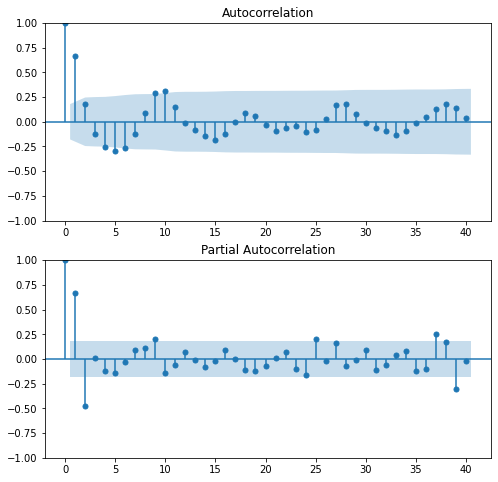

In [3]:
ts_series_ar2 = ARMA_simulate(ar_coef = [0.99, -0.9, 0.4], ma_coef = [1.0])
auto_partial_corr_plot(ts_series_ar2)

The AR(2) process produces a series with significant correlations in the lags, as shown in the  ACF plot. More importantly, the PACF has 2 significant non-zero lag values, consistent  with an AR(2) model. 

### Estimating the parameters of the AR models  

The AR time series model estimates the coefficients for the order of the model specified. The code in the cell below does the following:
1. Uses [statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html) to instantiate a model object. The order of the AR model is specified as (p,0,0). Notice that only the value of p is set in this tuple for a pure AR model. 
2. Fits the coefficient values using the fit method on the model object.
3. Prints the output of the summary method, showing useful statistics to understand the model.  
4. Returns the model. 

Run this code and examine  the  properties of the  results. 

In [4]:
def model_ARIMA(ts, order):
    model = ARIMA(ts, order = order)
 #   model_fit = model.fit(disp=0, method='mle', trend='nc')
    model_fit = model.fit()
    print(model_fit.summary())
    return(model_fit)
ar2_model = model_ARIMA(ts_series_ar2, order = (2,0,0))

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  120
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -173.163
Date:                Wed, 08 Nov 2023   AIC                            354.326
Time:                        15:07:07   BIC                            365.476
Sample:                    01-31-2005   HQIC                           358.854
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1422      0.197     -0.722      0.470      -0.528       0.244
ar.L1          0.9715      0.084     11.556      0.000       0.807       1.136
ar.L2         -0.4590      0.098     -4.702      0.0

Note the following about the AR model:

- The estimated AR coefficients have values fairly close to the values used to generate the data. Further, true values are within the standard errors and confidence intervals of the estimated coefficients. Notice negative sign of the coefficient values. 
- The p-values are small and standard error ranges do not include 0 so the coefficient values are significant. 

## Moving Average Model

For a **moving average** or **MA** model the value of the time series at time $t$ is determined by a linear combination of past error terms. In other words, the MA model accounts for the **serial correlation of errors** common in time series. We can write the MA(q) model as the linear combination of the last `q` errors, $\epsilon_i$:

\begin{align}
y_t &= c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}\\
& And,\\
\hat{y}_t &= c + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}\\
& Therefore,\\
\epsilon_t &= y_t - \hat{y}_t \sim \mathtt{N}(0,\sigma^2);\ error\ at\ time\ t \\
\end{align}

Where:    
c = a constant   
$\theta_k =$ model coefficient at lag $k$   
$y_t =$ observation at time $t$    
$\hat{y}_t =$ the value at time $t$ estimated from the past errors    
    

An MA process has the following autocorrelation properties:

- $\rho_0 = 1$ always.
- Number of nonzero $\rho_k \ne 0$ values $= q$.

MA models are specifically for **stationary time series**. Similarly to the autogregressive models, an MA model with a unit root is **not invertable** and therefore has model coeficients that are **non-identifiable**.    

The code in the cell below computes AR models and displays plots of the results. Run this code and examine the plots.

Is the time series stationary? True
Is the time series invertable? True
Is the time series stationary? True
Is the time series invertable? True
Is the time series stationary? True
Is the time series invertable? True
Is the time series stationary? True
Is the time series invertable? True


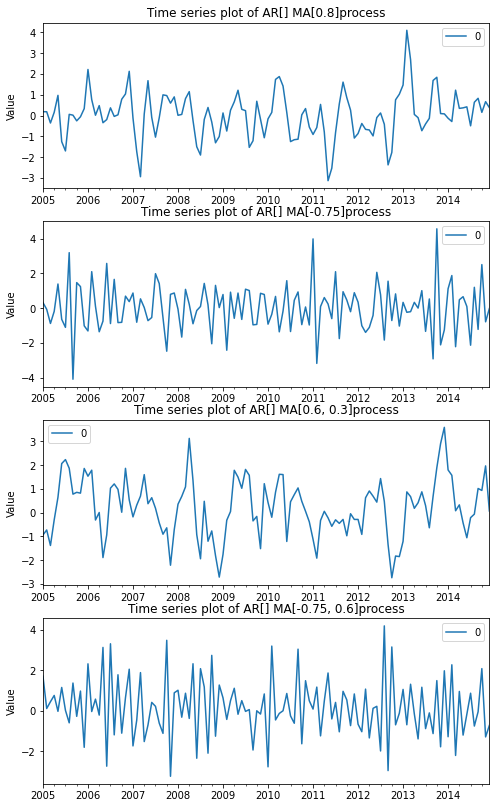

In [5]:
nr.seed(432)
ar_coefs_list = [[1], [1], [1], [1]]
ma_coefs_list = [[1.0, 0.8], [1, -0.75], [1.0, .6, 0.3], [1.0, -0.75, 0.6]]
plot_simulations(ar_coefs_list, ma_coefs_list)   

These MA process time series looks fairly random, with no trend. 

Next, execute the code in the cell below to plot the ACF and PACF of an MA(2) process. 

Is the time series stationary? True
Is the time series invertable? True


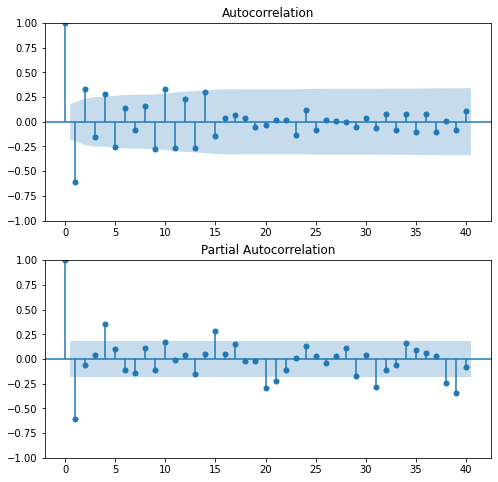

In [6]:
ts_series_ma1 = ARMA_simulate(ar_coef = [1], ma_coef=[1, -0.75, 0.6]) 
auto_partial_corr_plot(ts_series_ma1)

The ACF exhibits two non-zero lag, which is expected for an MA(2) process. There are also some significant non-zero lags in the PACF, which is a result of random noise.  

Let's try to estimate the coefficients of the MA time series. The code in the cell below fits and MA(1) model to the time series. The model is specified as `(0,0,q)`. Specifying only $q$ in the tuple defines a pure MA model. Execute this code and examine the result. 

In [7]:
ma1_model = model_ARIMA(ts_series_ma1, order = (0,0,2))

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  120
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -158.143
Date:                Wed, 08 Nov 2023   AIC                            324.287
Time:                        15:07:12   BIC                            335.436
Sample:                    01-31-2005   HQIC                           328.815
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.070      0.270      0.787      -0.118       0.155
ma.L1         -0.7751      0.077    -10.010      0.000      -0.927      -0.623
ma.L2          0.5760      0.071      8.080      0.0

Note the following about the AR model:

- The estimated MA coefficients have values close to the values used to generate the data. Further, the true values are within the standard error and confidence intervals of the estimated coefficients. 
- The p-values are small and standard error ranges do not include 0 so the coefficient values are significant. 

## The Autoregressive Moving Average Model

We can combine the AR and MA models to create an **autoregressive moving average** or **ARMA** model. This model accounts for serial correlation in both noise terms and values. As you might expect the ARMA model of order $(p,q)$ can be written as:

$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} \dots + \phi_p y_{t-p} +
 \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$
 
Or, rearranging the terms we get the commonly used form of this relationship:    
 
$$y_t -  c - \phi_1 y_{t-1} - \phi_2 y_{t-2} \dots - \phi_p y_{t-p} =  \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$

The ARMA model is only valid for stationary time series. Intuatively, if either side of the above equation has a zero value the system is not invertable and therefore non-idendifiable.   

The code in the cell below simulates and plots the results of several ARMA(p,q) models. Execute this code and examine the results. 

Is the time series stationary? True
Is the time series invertable? True
Is the time series stationary? True
Is the time series invertable? True
Is the time series stationary? True
Is the time series invertable? True
Is the time series stationary? True
Is the time series invertable? True


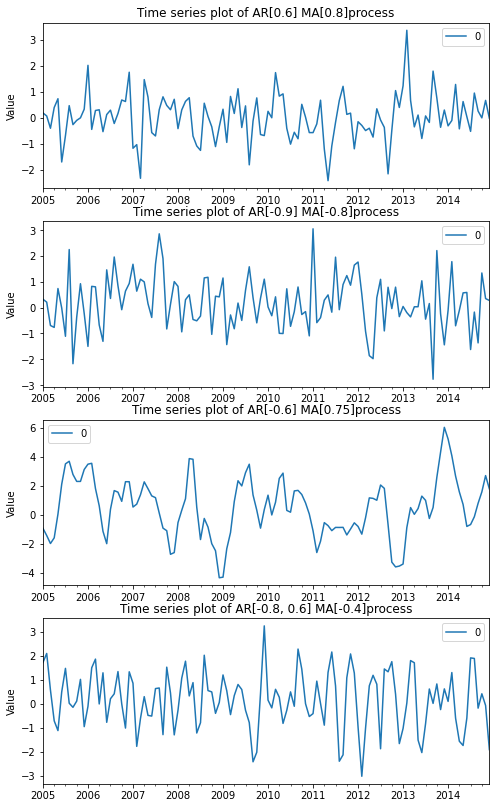

In [8]:
nr.seed(432)
ar_coefs_list = [[1.0, 0.6], [1.0, -0.9], [1.0, -0.6], [1.0,  -.8, .6]]
ma_coefs_list = [[1.0, 0.8], [1.0, -0.8], [1.0, 0.75], [1, -.4]]
plot_simulations(ar_coefs_list, ma_coefs_list)        

As we saw with time series generated by just AR or MA models, the ARMA time series show randomness, but no trend or random walk drift.  

To examine the ACF and PACF properties of the of an ARMA(p,q) time series, execute the code in the cell below.   

Is the time series stationary? True
Is the time series invertable? True


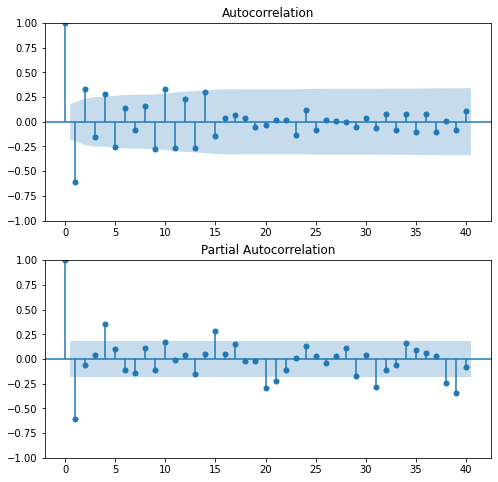

In [9]:
ts_series_arma21 = ARMA_simulate(ar_coef = [1, -.8, .6], ma_coef = [1, -.6])
auto_partial_corr_plot(ts_series_ma1)

> **Exercise 33-1:** Try estimating the parameters of the time series, printing a summary of the model and plot the ACF and PACF of the residual. **Hint**, the ARMA(2,1) model is specified as `order = (2,0,1)`.  

In [10]:
## Put your code below


                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  120
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -157.730
Date:                Wed, 08 Nov 2023   AIC                            325.460
Time:                        15:07:17   BIC                            339.397
Sample:                    01-31-2005   HQIC                           331.120
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0164      0.048      0.340      0.734      -0.078       0.111
ar.L1          0.6951      0.103      6.771      0.000       0.494       0.896
ar.L2         -0.6150      0.066     -9.267      0.0

> Examine the model summary and the plots and answer the following questions. 
> 1. How do the standard errors of the coefficients compare to the magnitudes of the coefficients? 
> 2. Do the p-values and confidence intervals indicate the coefficients are significant?
> 3. Is there any evidence that this model is overfit?   

> **Answers:**     
> 1.     
> 2.         
> 3.     

## Autoregressive Integrated Moving Average Model

The **autoregressive integrated moving average**, or **ARIMA** model adds an **integrating term**, $d$, to the ARMA model. Recall that a random walk is the sum or integral of previous innovations. Further, the random walk component is **non-stationary**. Using a differencing operator of **order d** the integrative non-stationary component of a time series can be eliminated as we investigated in the preious chapter. 

The ARIMA model is defined by orders (p,d,q). We have already looked at the AR(p) and MA(q) components. The d term defines the order of differencing required to remove random walk and trend components.  

In a previous section we simulated a random walk series, and investigated its properties. The first order difference operator is identical to the ARIMA(0,1,0) model.   

### Formulation of the ARIMA model    

We now use an example of formulating an $ARIMA(1,1,1)$ model. We will start with the $ARMA(1,1) = ARIMA(1,0,1)$ model.  

$$y_t -  c - \phi_1 y_{t-1} =  \epsilon_t + \theta_1 \epsilon_{t-1}$$

Now we take the first difference of the observations, $y_i$, to find the formulation of the $ARIMA(1,1,1)$ model.   

$$y_t -  y_{t-1} - \phi_1( y_{t-1} - y_{t-2}) =  \epsilon_t + \theta_1 \epsilon_{t-1}$$

The same algebra can be applied to finding polynomisal formulations for higher order ARIMA models.   

### forecasting with the ARIMA model

When forcasting our goal is to compute a point estimate, $\hat{y}_{t+H}$, $H$ time steps in the future, using the time series history, $[y_t, y_{t-1}, y_{t-2}, \ldots]$. For example, we can compute a forecast for a stationary time series with an $ARIMA(p,d,q)$ model by recursively applying a one step ahead forecast. For the forecasted value $\hat{y}_{t+H}$ we have no estimted error, $\epsilon_{t+H} = y_{t+H} - \hat{y}_{t+H}$.    

As an example, to make a forecast with an ARIMA(2,1,1) model:    

$$y_t -  y_{t-1} - \phi_1( y_{t-1} - y_{t-2}) - \phi_2 ( y_{t-2} - y_{t-3}) =  \epsilon_t + \theta_1 \epsilon_{t-1}$$

We can now model the one step ahead forecast as:     

$$\hat{y}_{t+1}= y_{t} - \phi_1( y_{t} - y_{t-1}) - \phi_1( y_{t-1} - y_{t-2}) + \theta_1 \epsilon_{t} + \epsilon_{t+1}$$

The two step ahead forecast is computed using a recursive relaitonship. However, there is no way to compute the error terms beyond the current observation at time $t$. Therefore we replace $\epsilon_{t+1}$ with the last known residual as $e_{t+2} = e_t$. The formulation is then:       

$$\hat{y}_{t+2}= \hat{y}_{t+1} - \phi_1( \hat{y}_{t+1} - y_{t}) - \phi_1( y_{t} - y_{t-1}) + \theta_1 e_{t}$$

Taking this recursion one more step, we must set any error terms, $\epsilon_i = 0$, since there is no way to estimate the value. This leaves the formulation:    

$$\hat{y}_{t+3}= \hat{y}_{t+2} - \phi_1( \hat{y}_{t+2} - y_{t+1}) - \phi_1( y_{t+1} - y_{t})$$

We can continue this recursion for as many time steps as desired. The same algebra can be used to work out the forecasting polynomial for higher order ARIMA models.  

### Forecasting errors   

When presented with any forecast, the first question should be 'what are the errors'? This problem is of particular concern, since the forecast is a **extrapolation** of the model into the future. Therefore, we cannot use the residuals, $\epsilon_i$, to estimate errors. Rather the errors themselves must reflect the uncertainty beyond the range of available observations in some way.  

In techincal terms, the forecast is a **point estimate**, which has a **confidence interval**. There are several ways which are commoinly used to compute confidence intervals:     
- **Theoretical sampling distribution:** Compute confidence intervals from a theoretical sampling distribution. This method is limited since deriving a suitable distribution can be difficult. Further, the actual sampling distribution is invariably different from the theoretical distribution.       
- **Bootstrap resampling:** In the absence of a thoretical sampling distribution we can use bootstrap resampling to compute a non-parametric sampling distribution. Bootstrap resampling of time series requires specific sampling methods, as a result of time ordering of the observations. Once an emperical sampling distributon has been sampled, the confidence intervals can be computed.               
- **Back-testing:** Another way to establish error limits is to use a backtesting algorithm. In backtesting the time series model is trained on a training portion of the data. Forecasts are made some time steps ahead, and errors calculated. The training window and forecast window is moved forward one or a few time steps at a time, and the process is repeated. The sampling distribution and the confidence intervals can be computed. In addition, standard error statistics such as RMSE and MAE can be computed from the back test.         

### Seasonal ARIMA     

We can easily extend the ARIMA model to include seasonal terms, the SARIMA model. The order of the model is written, $SARIMA(p,d,q)(P,D,Q)_M$. The lower case $(p,d,q)$ orders are the same as the, now familiar, ARIMA model for the residual. The upper case $(P,D,Q)_M$ orders are:   

- **P** is the order of the **seasonal AR term**. The model coefficients are written $\Phi_i$.    
- **D** is the order of differencing used to account for non-stationary behavior in the seasonal model.   
- **Q** is the order of the **seasonal MA term**. The model coefficients are written $\Theta_i$.    
- **M** is the seasonal period.   

The SARIMA model can be formulated as an additive or a multiplicative model of the components of a non-seasonal ARIMA model and the seasonal ARIMA model. The additive model can be expressed as $SARIMA \big[ (p,d,q) + (P,D,Q)_M \big]$. Alternatively, the multiplicative model can be expressed as $SARIMA \big[ (p,d,q)(P,D,Q)_M \big]$. As an example, we can write a multiplicative $SARIMA(1,1,1)(1,1,1)_M$ model:   

$$(y_t - \phi_1 y_{t-1})(y_t - \Phi_1 y_{t-M})(1-y_{t-1})(y_t - y_{t-M}) = (\epsilon_t - \theta_1 \epsilon_{t-1})(\epsilon_t - \Theta_1 \epsilon_{t-M})$$    

We can continue with this same algebra to find the polynomial of any $(p,d,q)(P,D,Q)$ or $(p,d,q)+(P,D,Q)$ order. In the maner of the previous section we can create a recussion to forecast future values.    

### Auto ARIMA    

Now, the question is, how do we find the 'best' ARIMA model? The [**auto ARIMA**](https://otexts.com/fpp2/arima-r.html) algorithm searches for a best SARIMAX model. The algorithm searches the space of p, q, P, and Q, to find the best fitting model as measured by an **information criteria**. Optionally, the algorithm can use a **random search** over the parameter space or use a **stepwise algorithm**. 

The auto ARIMA algorithm needs a metric to measure model performance. There are several possible choices. The Akaike Information Criteria or AIC is one option. The [Akaike Information criteria](https://en.wikipedia.org/wiki/Akaike_information_criterion), is named for its' invetor, Prof  Hirotsugu Akaike. The AIC is an information theoretic measure using the model likelihood and model complexity in terms of number of parameters, $k$:         
$$AIC = 2\ k - 2\ ln(\hat{L})$$

The **Bayesian Information Criteria** or **BIC** is another possibility and is closely related to the AIC. The BIC was proposed by Gideon Schwarz in 1978, and is sometimes referred to as the Schwarz Information Criteria. Like the AIC, the BIC seeks to minimize a penalized negative log-likelihood. However, the penalty term, $ln(n)\ p$, includes the weight for the log of the number of observations, $ln(n)$. The BIC weights the number of parameters, $p$, in the model by the log of the number of observations, rather than $2p$ for the AIC. We can write the BIC as:

$$BIC = ln(n)\ p - 2\ ln(\hat{L})\\
where\\
\hat{L} = the\ likelihood\ given\ the\ fitted\ model\ parmaters\ \hat\theta = p(x| \hat\theta)\\
x = observed\ data\\
p = number\ of\ model\ parameters\\
n = number\ of\ observations$$

The behavior of AIC and BIC are often quite similar. The best model has the smallest BIC, the penalized negative log-likelihood. For time series models, the BIC is generally preferred as it accounts for more complex models for cases with larger numbers of observations, or vice versa. 

## Real Data Example

Let's apply the models we have been working with on some real-world data. We will work with a data set which shows the consumption of chocolate, beer and electricity in Australia from 1958 to 1991. 

### Load and Examine the Data

As a first step, run the code in the cell below to load the data from the .csv file, add a time series index and examine the head and tail of the data frame. 

In [11]:
CBE = pd.read_csv('../data/cbe.csv')
CBE.index = pd.date_range(start = '1-1-1958', end = '12-31-1990', freq = 'M')
print(CBE.head())
print(CBE.tail())

            choc  beer  elec
1958-01-31  1451  96.3  1497
1958-02-28  2037  84.4  1463
1958-03-31  2477  91.2  1648
1958-04-30  2785  81.9  1595
1958-05-31  2994  80.5  1777
            choc   beer   elec
1990-08-31  8715  148.3  14338
1990-09-30  8450  133.5  12867
1990-10-31  9085  193.8  12761
1990-11-30  8350  208.4  12449
1990-12-31  7080  197.0  12658


As a next step we plot the three time series. Execute the code in the cell below to create these plots. 

Text(0.5, 1.0, 'Three Australian production time series')

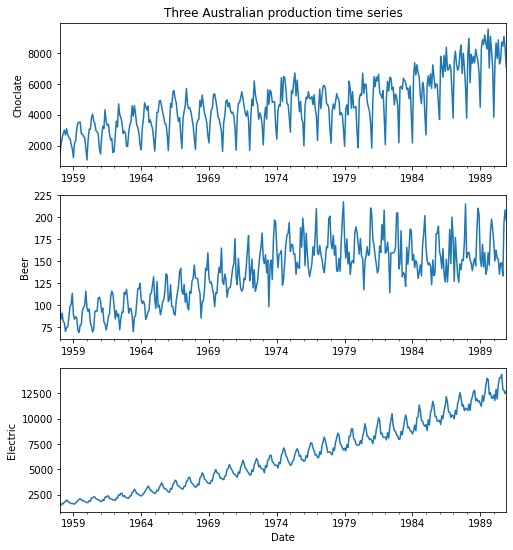

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,9))
CBE.choc.plot(ax = ax1)
CBE.beer.plot(ax = ax2)
CBE.elec.plot(ax = ax3)
ax1.set_ylabel('Choclate')
ax2.set_ylabel('Beer')
ax3.set_ylabel('Electric')
ax3.set_xlabel('Date')
ax1.set_title('Three Australian production time series')

Notice that for each of these time series the amplitude of the seasonal variation grows with time. This is a common situation with real world data. The variance of these time series is not costant in time. We say that the variance must be **stabalized** or made constant in time. In this case, we can try a log transformation of the time series values.          

Given that we hypothesize that a log transformation might stabilize the variance, a **multiplicative decomposition model** is approprate. The multiplicative model can be easily transformed to an additive model by taking the logarithm of the time series values. The code in the cell below performs the log transformation and plots the result for the electric consumption time series. Execute this code and  examine the results.    

Index(['choc', 'beer', 'elec', 'elec_log'], dtype='object')

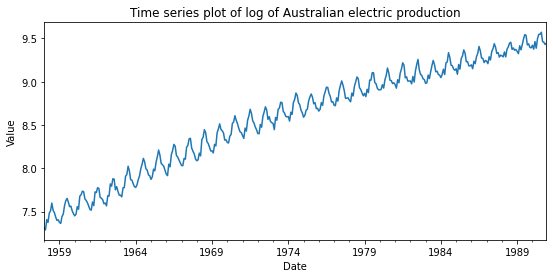

In [13]:
CBE['elec_log'] = np.log(CBE.elec)
plot_ts(CBE.elec_log, 'log of Australian electric production')
CBE.columns

Notice the following properties about this log-transformed time series.
- It has a a significant trend.
- The time series have a noticeable seasonal component.
- The seasonal component of the log transformed series has a nearly constant magnitude, but decreases a bit with time. This indicates the log transform has likely stabalized the variance.   

### Work flow for model creation     

There is a general workflow one can follow when creating a SARIMA time series model.       
1. **Determine seasonal difference order:** The first steps in building a SARIMA model is to remove non-stationary components. If the time series has seasonality one generally starts by using seasonal differencing to remove this component. Typically only a first difference at the period of the seasonality is required.          
2. **Determine difference order:** Once seasonal differencing has been performed, the time series is tested for stationarity. If the time series is not stationary differencing of the de-seasonalized series is performed. The differencing orders are tested until the residual series is stationary. In most cases a zero or first order differencing is required.          
3. **Find AR and MA coefficients:** The seasonal and non-seasonal AR and MA models are fit to the stationary residual. There are two possible ways to find the best model in terms of minimizing the BIC. The AR and MA order can be found by either mannual search or using an auto-ARIMA algorithm.    

### Example of workflow      

We will now apply this workflow to the log of the Austrailian electric production. This time series is clearly not stationary. There is both a trend and strong seasonaly behavior.  

To remove the seasonality we apply a differencing at the period of the seasonality, 12 months. Execute the code in the cell below to see the result.  

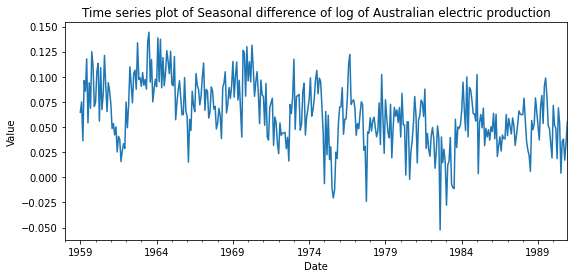

In [14]:
CBE['seasonal_diffs'] = CBE['elec_log'].diff(12)
plot_ts(CBE['seasonal_diffs'], 'Seasonal difference of log of Australian electric production')

It appears the that the first order differencing at the period of 12 months has removed the seasonal component of the time series. However, there may still be some random walk or other non-stationary component in the resulting series.     

Next, we can test for stationarity of the residual series.     

In [15]:
stationary_tests([CBE['seasonal_diffs'][12:]], ['Seasonal diff of log electricity'])

,ADF_statistic,ADF_conf_int,ADF_p_value,KPSS_statistic,KPSS_p_value
Seasonal diff of log electricity,-3.121,-2.869,0.025,1.65,0.01


The non-seasonal component of the series is not stationary. Therefore we will apply the first difference to this series. Execute the code in the cell below to do so and examine the result.   

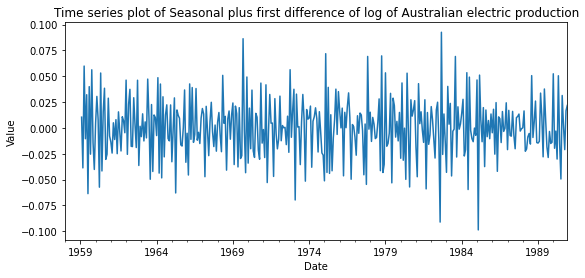

In [16]:
CBE['seasonal_first_diffs'] = CBE['seasonal_diffs'][12:].diff(1)
plot_ts(CBE['seasonal_first_diffs'], 'Seasonal plus first difference of log of Australian electric production')

The time series values in the plot look rather stationary. The question is now if the second differencing has resulted in a stationary time series. Execute the code in the cell below to verify that the result is stationary.    

In [17]:
stationary_tests([CBE['seasonal_first_diffs'][13:]], ['Seasonal + first diff of log electricity'])

,ADF_statistic,ADF_conf_int,ADF_p_value,KPSS_statistic,KPSS_p_value
Seasonal + first diff of log electricity,-7.746,-2.869,0.0,0.088,0.1


The p-values of the ADF and KPSS tests indicate that the result of the second differencing is stationary.      

Now, execute the code in the cell below to display the ACF and PACF of the second differenced series.   

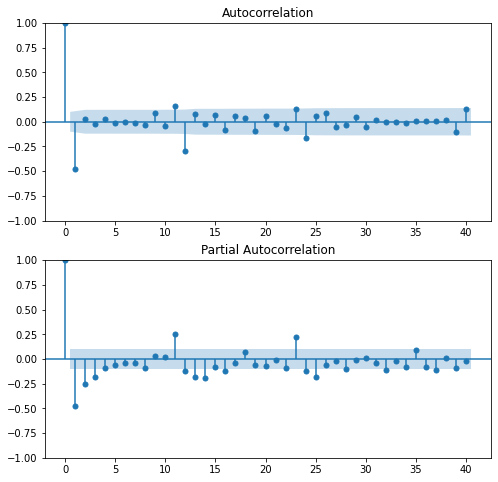

In [18]:
## dist_ts(CBE['seasonal_first_diffs'][13:], 'Seasonal + first diff of log electricity') 
auto_partial_corr_plot(CBE['seasonal_first_diffs'][13:])

THere is some evidence of correlation in the difference time series, both seasonal and non-seasonal.

### Fitting a SARIMA model    

The next step is to find the best order and seasonal order of a SARIMA model. The [pmdarima.arima.auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) function, from the Pmdarima package, performs a grid search over the orders of a SAEIMA$(p,d,q)(P,D,Q)$ model. The grid search finds the model with the smallest BIC value. Limits are set on the model parameters to speed the search. We already know the differencing orders, $d=1$ and $D=1$, which gave us the stationary series. We only need to find values for $p$, $q$, $P$ and $Q$. Further, based on the ACF and PACF shown above limits for these parameters can be set.   

In this case, the last 12 months of the time series are not used to fit the model. These values are held back for model evaluation. 

Execute the code in the cell below to perform the grid search over the limits of the parameters specified. The search may take some time.      

In [19]:
Log_electric = CBE.elec_log[:'1989-12-31']
best_model = pm.auto_arima(Log_electric, 
                             max_p=3, max_q=3, 
                             max_P=3, max_Q=3, 
                             m=12, seasonal=True,
                             d=1, D=1, trace=True,
                             information_criterion = 'bic',
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=-1783.255, Time=29.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=-1572.064, Time=0.54 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=-1696.322, Time=5.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=-1800.249, Time=14.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=-1699.081, Time=0.25 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=-1800.515, Time=19.23 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=-1742.451, Time=4.40 sec
 ARIMA(0,1,1)(2,1,1)[12]             : BIC=-1797.601, Time=76.96 sec
 ARIMA(0,1,1)(1,1,2)[12]             : BIC=-1797.841, Time=104.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : BIC=-1802.021, Time=107.23 sec
 ARIMA(0,1,1)(0,1,3)[12]             : BIC=-1797.795, Time=80.47 sec
 ARIMA(0,1,1)(1,1,3)[12]             : BIC=-1790.039, Time=26.43 sec
 ARIMA(0,1,0)(0,1,2)[12]             : BIC=inf, Time=5.68 sec
 ARIMA(1,1,1)(0,1,2)[12]             : BIC=-1796.168, Time=84.11 sec


We have now found the optimal model is SARIMA$(0,1,1)(0,1,2)_{12}$. To display a summary of the model fit, execute the code in the cell below. 

In [20]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  384
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 912.843
Date:                                 Wed, 08 Nov 2023   AIC                          -1817.686
Time:                                         15:19:51   BIC                          -1802.021
Sample:                                     01-31-1958   HQIC                         -1811.464
                                          - 12-31-1989                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6351      0.039    -16.379      0.000      -0.711      -0.559
ma.S.L12      -0.5897      0.061     -9.598      0.000      -0.710      -0.469
ma.S.L24      -0.1578      0.062     -2.551      0.011      -0.279      -0.037
sigma2         0.0004   2.63e-05     15.833      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                10.94
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.23
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Examine the summary of the model and notice the following:     
- All of the model coefficients are significant and with relatively small standard errors. indicating the fit of the model is well-determined.         
- The Ljung-Box test indicates that there is no serial correlation in the residuals. In other words, there is no predictive information not accounted for.            
- The heteroskedasticity test indicates that the residuals are homoskedastic.      
- The Jarque-Bera test indicates there is some significant skew or krutosis.      

### Forecasting with SARIMA   

The selected SARIMAX model can be used for prediction of time series values. Recall that the model parameters were estimated using all but the last 12 months of data. We will now make predictions from the model and compare the results to the known values.   

There is one Statsmodels specific complication we need to deal with. We what to include confidence intervals with our prediction. Therefore, we need to use the `get_forecast` method of the [statsmodels.tsa.statespace.sarimax.SARIMAX](https://www.statsmodels.org/0.9.0/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) model. As a result we need to fit this new model using the model order found to be optimal.        

The code in the cell below performs prediction with the prediction method. A Pandas series is created from the results. Execute this code and examine the results.

In [21]:
SARIMAX_model = SARIMAX(Log_electric[:'1989-12-31'], order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
prediction = SARIMAX_model.get_forecast(12, dynamic=True).summary_frame()
prediction

elec_log,mean,mean_se,mean_ci_lower,mean_ci_upper
1990-01-31,9.390022,0.020634,9.349580,9.430463
1990-02-28,9.366448,0.021801,9.323718,9.409178
1990-03-31,9.447889,0.022910,9.402987,9.492791
1990-04-30,9.401389,0.023967,9.354415,9.448362
1990-05-31,9.488275,0.024979,9.439317,9.537233
1990-06-30,9.532037,0.025952,9.481172,9.582902
1990-07-31,9.590992,0.026890,9.538289,9.643695
1990-08-31,9.568314,0.027796,9.513835,9.622793
1990-09-30,9.476324,0.028673,9.420125,9.532523
1990-10-31,9.483688,0.029525,9.425821,9.541556


The code in the cell below plots the actual values and the 12 predicted values for two time periods. Execute this code and examine the results.   

Text(0.5, 0, 'Date')

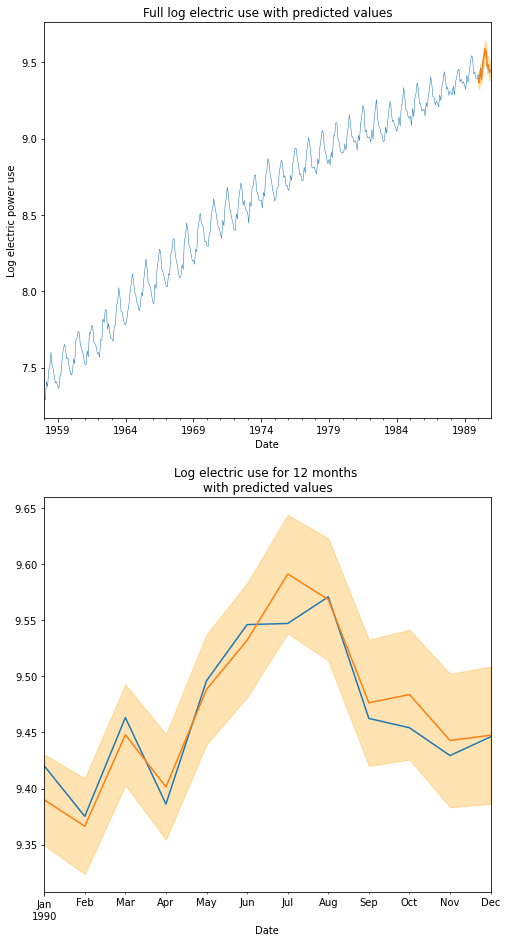

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 16))
#Log_electric.plot(ax=ax[0])
CBE.elec_log.plot(ax=ax[0], lw=0.5)
prediction['mean'].plot(ax=ax[0])
ax[0].fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='orange', alpha=0.3)
ax[0].set_title('Full log electric use with predicted values')
ax[0].set_ylabel('Log electric power use')
ax[0].set_xlabel('Date')

CBE.elec_log['1990-01-31':].plot(ax=ax[1])
prediction['mean'].plot(ax=ax[1])
ax[1].fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='orange', alpha=0.3)
ax[1].set_title('Log electric use for 12 months \nwith predicted values')
ax[1].set_xlabel('Date')

The predicted values are close to the actual values. Further the actual values are well within the confidence intervals of the forecast.  

We should also look at the **out of sample** residuals. Execute the code in the cell below to compute the residuals and the standard deviation (RMSE) of the residuals and examine the results

In [23]:
residuals = CBE.elec_log['1990-01-31':] - prediction['mean']
print(residuals)
print('\nThe RMSE of the residuals = {}'.format(np.round(np.std(residuals), 4)))

1990-01-31    0.030255
1990-02-28    0.008814
1990-03-31    0.015309
1990-04-30   -0.015164
1990-05-31    0.007695
1990-06-30    0.013918
1990-07-31   -0.044037
1990-08-31    0.002355
1990-09-30   -0.013903
1990-10-31   -0.029539
1990-11-30   -0.013386
1990-12-31   -0.001423
Freq: M, dtype: float64

The RMSE of the residuals = 0.0199


The residuals are small as is the RMSE, when compared to the values in the log series.    

There is one more thing we will do. Verify that the residuals have a Normal distribution and have no further predictive information. Execute the code in the cell below and examine the results.  

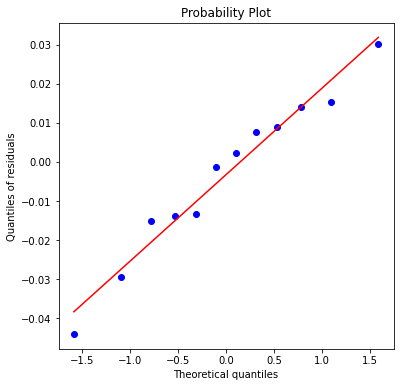

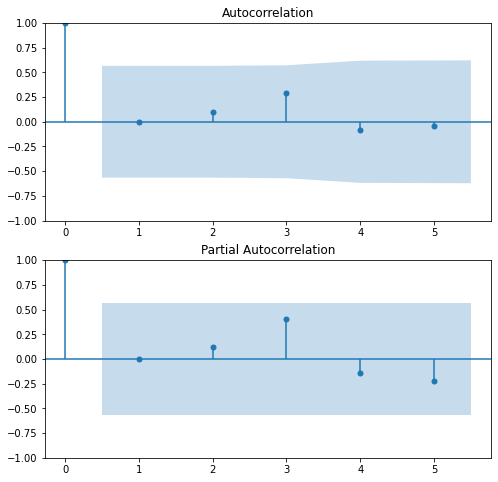

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
_=ss.probplot(residuals, plot = ax)
plt.ylabel('Quantiles of residuals');
auto_partial_corr_plot(residuals, lags=5)

The distribution of the residuals appears close to Normal. Further, the non-zero lags are all within the 95% confidence interval, indicating there is no further predictive information not accounted for by the model.  

**Further verification:** To complete the tests on the model, the residual for the entire observed data series should be analyzed. To do this you can use the [predict method with the start and stop arguments](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.predict.html#statsmodels.tsa.arima_model.ARIMA.predict) to make predictions over the entire date range.  

## Another Example

You will now work though another example. In this case you will create a model and make predictions of milk production in the state of California. The data cover the period of 1995 to 2014. These data were compiled from the State of California Department of Agriculture.                

As a first step execute the code in the cell below to import the dataset and display the head of the data frame.    

In [25]:
CA_dairy = CBE = pd.read_csv('../data/cadairydata.csv')
## Give the columns some more Python friendly names
CA_dairy.columns = ['Unnamed', 'Year_Month', 'Month_Number', 'Year', 'Month',
       'Cotagecheese_Prod', 'Icecream_Prod', 'Milk_Prod',
       'N_CA_Fat_Price']

## Create a timestamp index for the data frame
CA_dairy['Year_Month'] = CA_dairy['Year_Month'].apply(str).replace('.', '-')
CA_dairy.index = pd.to_datetime(CA_dairy.Year_Month, format = '%Y.%m')

## Some messy code to correct an timestamp error in original data
temp_index = pd.Series(CA_dairy.index) 
temp_index[225] = '2013-10-01'
CA_dairy.index = temp_index

## Remove unneeded columns
CA_dairy.drop(['Unnamed','Year_Month','Month_Number','Year','Month'], axis=1, inplace=True)
CA_dairy.head(12)

,Cotagecheese_Prod,Icecream_Prod,Milk_Prod,N_CA_Fat_Price
Year_Month,,,,
1995-01-01,4.370,51.595,2.112,0.9803
1995-02-01,3.695,56.086,1.932,0.8924
1995-03-01,4.538,68.453,2.162,0.8924
1995-04-01,4.280,65.722,2.130,0.8967
1995-05-01,4.470,73.730,2.227,0.8967
1995-06-01,4.238,77.994,2.124,0.9160
1995-07-01,4.377,81.475,2.184,0.9160
1995-08-01,4.368,74.981,2.152,0.8934
1995-09-01,3.917,61.530,2.062,0.8934


As you can see there are 4 time-ordered variables in this dataset. For this eaxample you will only focus on one, milk production.     

To display a time series plot of California milk production, execute the code in the cell below.  

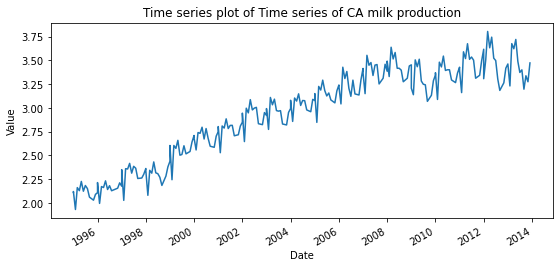

In [26]:
plot_ts(CA_dairy['Milk_Prod'], 'Time series of CA milk production')

> **Exercise 33-2:** The variance of the milk production time series appears to increase with time or value. A log transformation could stabalize this time series. To test this idea try the following:       
> 1. Add a column named `Log_Milk_Prod` to the `CA_dairy` data frame using [numpy.log](https://numpy.org/doc/stable/reference/generated/numpy.log.html).      
> 2. Plot the result using the `plot_ts` function.   

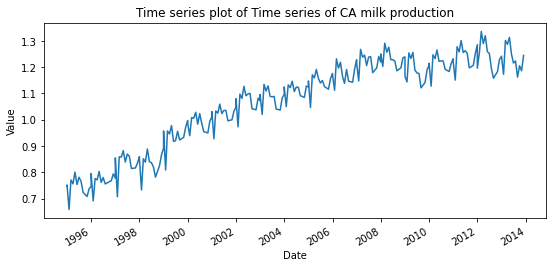

In [27]:
## Put your code below



> Does the variance appear fairly constant over the length of the time series. In other words are is the variance stabalized and why?  

> **Answer:**       

> **Exercise 33-3:** This time series is not stationary given the seasonal component and the trend. You will now do the following to remove the seasonal component:     
> 1. Add a column to the data frame named `seasonal_diffs`, taking a difference at 12 periods.        
> 2. Plot the seasonal differences time series with the `plot_ts` function.  

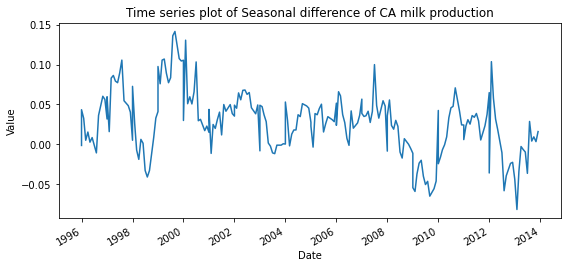

In [28]:
## Put your code below



> Examine the resulting time series. Does the time series look stationary? Now, run the code in the cell below to apply hypothesis tests of stationarity to the seasonal difference series.      

In [29]:
stationary_tests([CA_dairy['seasonal_diffs'][12:]], ['Seasonal diff of log milk'])

,ADF_statistic,ADF_conf_int,ADF_p_value,KPSS_statistic,KPSS_p_value
Seasonal diff of log milk,-2.881,-2.876,0.048,0.615,0.021


> Based on the time series plot and the stationarity hypothesis tests is the seasonal difference series stationary and why?    

> **Answer:**    

> **Exercise 33-4:**  To ensure the series is stationary, you will now do the following to apply a first difference:     
> 1. Add a column to the data frame named `seasonal_first_diffs`, taking first differences on the `seasonal_diffs` series.           
> 2. Plot the first and seasonal differences time series with the `plot_ts` function.   
> 3. Apply the `stationary_tests` function to the `seasonal_first_diffs` time series. Make sure not to include the first 13 samples, since they are all `NaN` as a result of the differencing.      

,ADF_statistic,ADF_conf_int,ADF_p_value,KPSS_statistic,KPSS_p_value
Seasonal first diffs of log milk,-6.097,-2.876,0.0,0.035,0.1


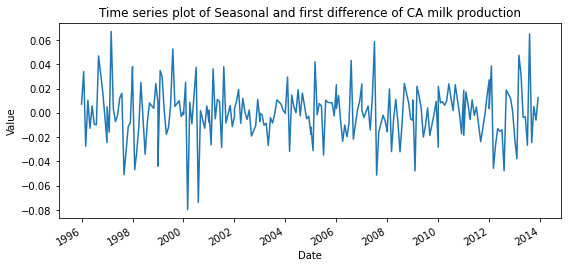

In [30]:
## Put your code below




> Examine the results above. Does the series resulting from the two differencing operations now appear to be stationary and why?       

> **Answer:**    

A stationary time series can still have a stochastic time dependency. To investigate further execute the code in the cell below to display the ACF and PACF plots of the twiced differenced time series.

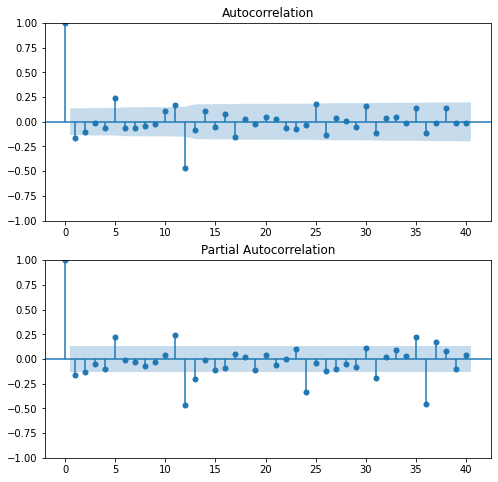

In [31]:
auto_partial_corr_plot(CA_dairy['seasonal_first_diffs'][13:])

There are some significant non-zero lags in both the ACF and PACF, particularly at the period of the seasonality. A SARIMA model is justified.     

> **Exercise 33-5:** Your next step is to find optimal SARIMA(p,d,q)(P,D,Q) orders. Do so with the [pmdarima.arima.auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) function. You can use the same arguments as were used for the log electric produciton time series. Display a summary of the best model found.        

In [32]:
## Put your code below



















Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=-1118.561, Time=30.45 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=-1028.053, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=-1086.710, Time=9.91 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=-1137.667, Time=7.48 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=-1030.354, Time=0.28 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=-1133.604, Time=8.61 sec
 ARIMA(0,1,1)(0,1,2)[12]             : BIC=-1134.115, Time=20.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=-1087.779, Time=11.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : BIC=-1127.866, Time=69.14 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=-1138.930, Time=2.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : BIC=-1134.794, Time=3.83 sec
 ARIMA(0,1,0)(0,1,2)[12]             : BIC=-1135.326, Time=6.43 sec
 ARIMA(0,1,0)(1,1,0)[12]             : BIC=-1084.138, Time=2.16 sec
 ARIMA(0,1,0)(1,1,2)[12]             : BIC=-1129.118, Time=37.23 sec


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  228
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 574.835
Date:                              Wed, 08 Nov 2023   AIC                          -1145.671
Time:                                      15:24:11   BIC                          -1138.930
Sample:                                           0   HQIC                         -1142.947
                                              - 228                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.8444      0.055    -15.230      0.000      -0.953      -0.736
sigma2         0.0003   1.87e-05     13.923      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   3.67   Jarque-Bera (JB):                28.91
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.03
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> Next, use the order of the best model to fit a SARIMAX model using [statsmodels.tsa.statespace.sarimax.SARIMAX](https://www.statsmodels.org/0.9.0/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). Use the following steps:     
> 1. Create a Pandas series from the `Log_Milk_Prod` column of the CA_dairy data frame.    
> 2. Instatiate and fit the SARIMA model, holding back the last 12 months of observations.     
> 3. Compute a forecast of the final 12 months of the observations.      
> 4. Add the index to the Pandas series of the predictions, named `dairy_predictions`. This code is a bit tricky with Pandas. the following works, but will produce some seemingly meaningless warning messages:      

> 5. Display the predictions and examine the results.  

In [33]:
## Put your code below





/home/mesaleh/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mesaleh/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mesaleh/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mesaleh/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mesa

Log_Milk_Prod,mean,mean_se,mean_ci_lower,mean_ci_upper
Year_Month,,,,
2013-01-01,1.244957,0.016118,1.213366,1.276548
2013-02-01,1.177796,0.022793,1.133123,1.222470
2013-03-01,1.286796,0.027915,1.232084,1.341508
2013-04-01,1.263235,0.032233,1.200060,1.326410
2013-05-01,1.292392,0.036037,1.221761,1.363023
2013-06-01,1.243790,0.039476,1.166418,1.321162
2013-07-01,1.246188,0.042639,1.162617,1.329759
2013-08-01,1.238204,0.045583,1.148863,1.327545
2013-09-01,1.195931,0.048348,1.101170,1.290691


> To display your model results exectue the code in the cell below which does the following:   
> 6. Display the full log California milk production time series and the predictions with the confidence interval range.   
> 7. Display a plot of the 12 month forecast period showing the actual time series values and the predictions with the confidence intervals shaded.    

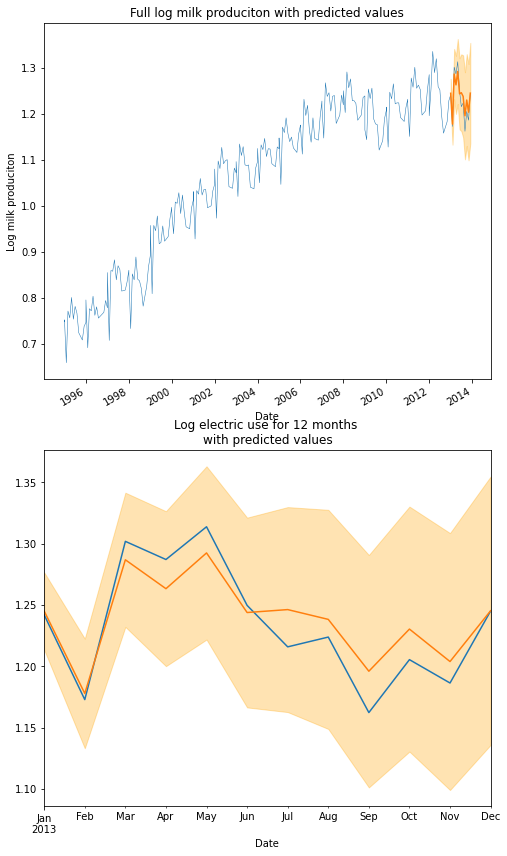

In [34]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 16))
CA_dairy['Log_Milk_Prod'].plot(ax=ax[0], lw=0.5);
dairy_prediction['mean'].plot(ax=ax[0]);
ax[0].fill_between(dairy_prediction.index, dairy_prediction['mean_ci_lower'], dairy_prediction['mean_ci_upper'], color='orange', alpha=0.3);
ax[0].set_title('Full log milk produciton with predicted values')
ax[0].set_ylabel('Log milk produciton')
ax[0].set_xlabel('Date')

CA_dairy.Log_Milk_Prod['2013-01-01':].plot(ax=ax[1])
dairy_prediction['mean'].plot(ax=ax[1])
ax[1].fill_between(dairy_prediction.index, dairy_prediction['mean_ci_lower'], dairy_prediction['mean_ci_upper'], color='orange', alpha=0.3)
ax[1].set_title('Log electric use for 12 months \nwith predicted values')
ax[1].set_xlabel('Date');

> Examine the results and answer the following questions:      
> 1. What does the order of the SARIMA model tell you about the stochastic components of the time series following the two differencings?      
> 2. Given the results of the Heteroskedasticity test of the SARIMA model is it reasonable to conlcude the residuals are Homoskedasitc, and why?  
> 3. Given the standard errors and confidence intervals of the forecasted values, are these forecasts consistent with the observatons?

> **Answers:**     
> 1.       
> 2.      
> 3.     

> **Exercise 33-6:** You will now perform a more detailed analysis of the residuals (errors) of the forecasted values by the following steps:      
> 1. Compute the residuals of the forecasts to create a Pandas series.      
> 2. Display the series of residuals.   
> 3. Compute and display the RMSE of the residuals.   
> 4. Display the Q-Q plot of the residuals.   
> 5. Plot the ACF and PACF for the first 5 lags of the residuals.  

Year_Month
2013-01-01   -0.003110
2013-02-01   -0.005005
2013-03-01    0.015029
2013-04-01    0.023791
2013-05-01    0.021332
2013-06-01    0.005825
2013-07-01   -0.030385
2013-08-01   -0.014429
2013-09-01   -0.033718
2013-10-01   -0.024923
2013-11-01   -0.017503
2013-12-01   -0.000214
dtype: float64

The RMSE of the residuals = 0.0187


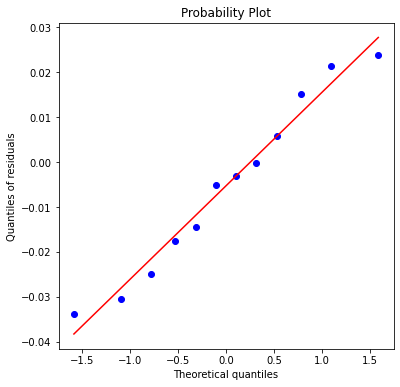

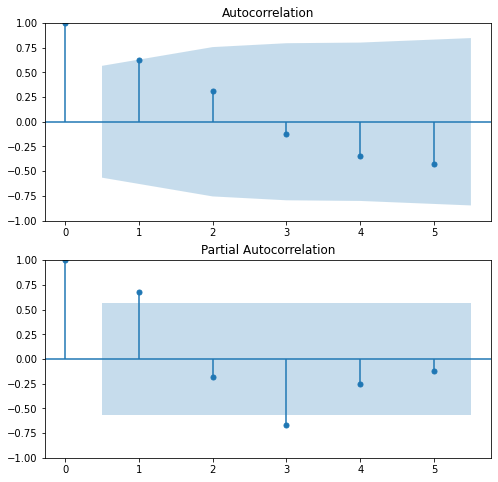

In [35]:
## Put your code below








> Examine the results and answer the following questions:     
> 1. Compare the standard errors confidence intervals to the forecasted values. A do these SEs and CIs indicate the forcast has statistical significance and why?      
> 2. Continuing with examination of the standard errors confidence intervals does it make sense that these measures increase with time into the future and why? 
> 3. Are the forcasted values within the CIs of the observed values, and what does this tell you about the usefulness of the forecast?     
> 4. Notice that the residuals are small compared to the predicted values. Are these residuals reasonbly Normally distributed?    
> 5. Is there evidence from the ACF or PACF that the stochanstic component of the series still has significant predictive information, and is this result consistent with the results of the the Jlung-Box test on the residuals of the SARIMA model?

> **Answers:**   
> 1.        
> 2.       
> 3.      
> 4.      
> 5.      

## Models for Non-Stationary Variance.

The **Autoregressive conditional heteroscedastic** or **ARCH** and **Generalized Autoregressive conditional heteroscedastic** or **GARCH** model, and their many relatives, are specifically intended to deal with variance which changes with time. Robert Engle published the ARCH model in 1982 for which he was awarded the Nobel Prize in Economics in 2003. 

These models are beyond the scope of this lesson. Additional information can be found in the references given earlier. Software packages for these models are widely available, including in R and Python.  

#### Copyright 2018, 2019, 2020, 2021, 2022, 2023 Stephen F Elston. All rights reserved.  

## Appendix: Exponential Smoothing of Time Series

The idea of using exponential smoothing for time series analysis is an old one, dating at least to use by Weiner in the 1920s. The related idea of moving average filters was developed by Kolmogorov and Zurbenko in the 1940s. Exponential smoothers were used extensively in signal processing in the 1940s. The general idea was expanded by Robert Goodell Brown (1956) and C.E. Holt (1957) and his student P.R. Winters (1960). The higher-order Holt-Winters model accounts for trend and seasonality of time series.      

## Basic exponential Smoothing

Exponential smoothing uses a weighted sum of the current observation and the past smoothed value to compute a new smoothed value. This basic exponential smoothing relationship is shown below.  

$$
s_0 = y_0 \\
s_t = \alpha y_t + (1-\alpha) s_{t-1} = s_{t-1} \alpha(y_t - s_{t-1}),\ t \gt 0
$$

The smoothing hyperparameter, $\alpha$, controls the trade-off between the last observation and the previous smoothed values. The possible values are in the range, $0 \le \alpha \le 1$. A large value of $\alpha$ puts more weight on the current observation. Whereas, a small value of $\alpha$ puts more weight on the smoothed history.      

How can we understand the exponential decay of the smoothed history of a time series. The smoothing hyperparameter, $\alpha$, can be expressed in terms of the decay constant, $\tau$ and time interval $\delta T$ as shown below.  

$$
\alpha = 1 - e^{\big( \frac{- \Delta T}{\tau} \big)}
$$

From this relationship you can see that the influence of the smoothed history decays exponentially as $\delta T$ increases. The decay time increases as $\tau$ decreases.   

### Smoothing with higher-order terms   

The basic exponential smoothing algorithm is effective in many cases. However, the simple first order exponential smoothing method cannot accommodate time series with trend or seasonality. Higher order smoothing models are required.   

The **double exponential smoothing** or **Holt-Winters double exponential smoothing** algorithm is a second order smoothing method. Using two coupled difference equations a trend and non-seasonal component of the time series can be modeled. The model updates a smoothed measure of the non-seasonal component and the trend.   

The model is initialized with the values:   
$$
s_1 = y_1 \\
b_1 = y_2 - y_1
$$

At each time step the pair of time difference equations are updated. The following relationships update the smoothed non-seasonal component, $s_t$, and the slope, $b_t$:   

$$
s_t = \alpha y_t + (1-\alpha) (s_{t-1} + b_{t-1}) \\
b_t = \beta(s_t - s_{t-1}) + (1 - \beta)b_{t-1}
$$

The smoothed non-seasonal component and smoothed slope can be used to compute a forecast. The relationship below computes the forecast $m$ time steps ahead.      

$$ F_{t+m} = s_t + m b_t $$   

What about seasonal components? A third-order difference relationship can include a smoothed seasonal component, along with the smoothed non-seasonal and slope components. The details of this process are not discussed further here. The details are available elsewhere, including the [exponential smoothing Wikipedia page](https://en.wikipedia.org/wiki/Exponential_smoothing#:~:text=Exponential%20smoothing%20is%20a%20rule,exponentially%20decreasing%20weights%20over%20time.).  

### Example of exponential time series smoothing   

A simple example of exponential smoothing of a time series will help illustrate some of the foregoing ideas. Here, we apply the Holt-Winters smoothing to the linear trend series with white noise. This series was analyzed earlier.   

The code in the cell below uses the [statsmodels.tsa.holtwinders.ExponentialSmoothing](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html) function. Multiple values of the non-seasonal smoothing hyperparameter, $\alpha$, are used. The trend smoothing hyperparameter, $\beta$, is held constant. A time series plot is created showing the original series and three values of the non-seasonal smoothing hyperparameter.    

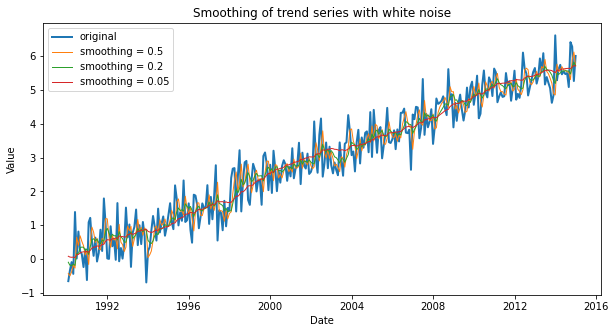

In [36]:
import warnings
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(trends, label='original', linewidth=2)

Holt_model = ExponentialSmoothing(trends, trend='add', seasonal=None)

for smoothing in [0.5,0.2,0.05]:
    warnings.filterwarnings("ignore")
    Holt_model_fit = Holt_model.fit(smoothing_level=smoothing, smoothing_slope=0.05)
    label = 'smoothing = ' + str(smoothing)
    ax.plot(Holt_model_fit.fittedvalues, label = label, linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Smoothing of trend series with white noise')
plt.legend()    

Examine the results above. The original simulated time series values show the presence of the white noise. Notice that the smoothed series becomes closer to the actual linear trend as the non-seasonal smoothing hyperparameter decreases. Forecasts based on the model with $\alpha = 0.05$ can be expected to extrapolate the linear trend.  